<center>
    <h1>
        Term identification system for a specific domain
    </h1>
    Rameez Qurashi, Abdelhak Zabour
    </center>
    

In [1]:
# PhraseMatcher.py
# import necessary modules

from __future__ import unicode_literals, print_function


from pathlib import Path
from spacy.util import minibatch, compounding
from spacy.pipeline import EntityRuler
from spacy.lang.en import English
from spacy import displacy
from collections import Counter
from spacy.matcher import PhraseMatcher #import PhraseMatcher class
#from nltk.chunk import conlltags2tree, tree2conlltags
from pprint import pprint
from time import sleep
from progressbar import progressbar
from spacy.tokens import Span
from spacy.util import minibatch, compounding
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import random
import plac
import warnings
import pandas as pd
import numpy as np
import xlrd
import spacy
#import en_core_web_sm
#import json 
import re

plt.rcParams["figure.figsize"] = (15,10)

#nltk.download('punkt')

# Language class with the English model 'en_core_web_sm' is loaded
#nlp = spacy.load('en_core_web_sm')
#nlp.max_length = 7000000

In [9]:
    
def extract_entities(doc):
    dict_new_ents = {}
    list_new_ents = []
    for ent in doc.ents:
        # Only check
        if ent.label_ == "AstroTerm":
            
            
            list_new_ents.append((ent.start_char, ent.end_char, ent.label_))      
    
    dict_new_ents['entities'] = list_new_ents
            
    return (doc.text,dict_new_ents )


## Read the list of terminology 

In [2]:
terms_corpus = pd.read_excel('astronomy.xls')

In [3]:
# the list containing the pharses to be matched
terminology_list = []
for term in terms_corpus['key']:
    terminology_list.append(term[term.find(':')+2:])

## text for training:

In [4]:
# read the texts from corpus
file = open('corpus/result.txt')
text = file.read()

In [5]:
nlp_rule_based = English()
ruler = EntityRuler(nlp_rule_based)

In [6]:
# create patterns
patterns = []

for term in terminology_list:
    dct = {}
    temp = term.split()
    if len(temp) == 1:
        dct["label"] = "AstroTerm"
        dct["pattern"] = temp[0]
        patterns.append(dct)
    else:
        lst = []
        for item in temp:
            dct_temp = {}
            dct_temp["lower"] = item
            
            lst.append(dct_temp)
            
        dct["label"] = "AstroTerm"
        dct["pattern"] = lst
        patterns.append(dct)

In [7]:
# add patterns and pipe
ruler.add_patterns(patterns)
nlp_rule_based.add_pipe(ruler)

In [10]:
# generate annotated data
train_data = []
for doc in nltk.tokenize.sent_tokenize(text):
    doc = nlp_rule_based(doc)
    train_data.append(extract_entities(doc))

## Neural Network approach:

In [11]:
# upload the saved model
output_dir = "output_dir"
print("Loading from", output_dir)
nlp_seq = spacy.load(output_dir)

Loading from output_dir


In [12]:
# text test
text_test = input("Enter your testing text: ")

Enter your testing text: Gravity, the ubiquitous attractive force that pervades our Universe, is a significant driver of galaxy formation. Gravity makes galaxies collide, and these collisions can affect various properties -- merging drives strong star formation in the galaxies in question, increases the masses of their constituent black holes and can significantly alter the internal structure of the galaxies.  Our classical paradigm has often assumed that mergers between equal mass progenitors ('major' mergers) have the most transformative impact on galaxies. However, such events are rare. Much more common are mergers between massive galaxies and small satellites ('minor' mergers). This is because small galaxies far outnumber their more massive counterparts -- the attractive nature of gravity then ensures that these massive galaxies are constantly being bombarded by satellites.  While major mergers are more spectacular and easier to study because they tend to be brighter, studying mino

In [ ]:
# test text
#file = open('test_corpus/text09.txt')
#text_test = file.read()

## Comparison between two approaches

In [13]:
# run the neural network model
doc = nlp_seq(text_test)
entities = [(ent.text, ent.label_) for ent in doc.ents]
#print("Entities", entities)
counter_nn = Counter(entities)
counter_nn

Counter({('galaxy formation', 'AstroTerm'): 1,
         ('star formation', 'AstroTerm'): 3,
         ('mass', 'AstroTerm'): 1,
         ('gravity', 'AstroTerm'): 1,
         ('exposure', 'AstroTerm'): 1,
         ('faint', 'AstroTerm'): 1,
         ('tidal', 'AstroTerm'): 1,
         ('galaxy', 'AstroTerm'): 2})

In [14]:
# run rule based model
doc = nlp_rule_based(text_test)
entities = [(ent.text, ent.label_) for ent in doc.ents]
#print("Entities", entities)
counter = Counter(entities)
counter

Counter({('galaxy', 'AstroTerm'): 3,
         ('star formation', 'AstroTerm'): 3,
         ('mass', 'AstroTerm'): 1,
         ('gravity', 'AstroTerm'): 1,
         ('exposure', 'AstroTerm'): 1,
         ('faint', 'AstroTerm'): 1,
         ('tidal', 'AstroTerm'): 1})

In [ ]:
#displacy.render(matched_sents, style="ent", manual=True)


In [15]:
# create list for visualization
terms_nn = [[ter, val] for ter, val in zip(counter_nn.keys(),counter_nn.values())]
terms_RB = [[ter, val] for ter, val in zip(counter.keys(),counter.values())]

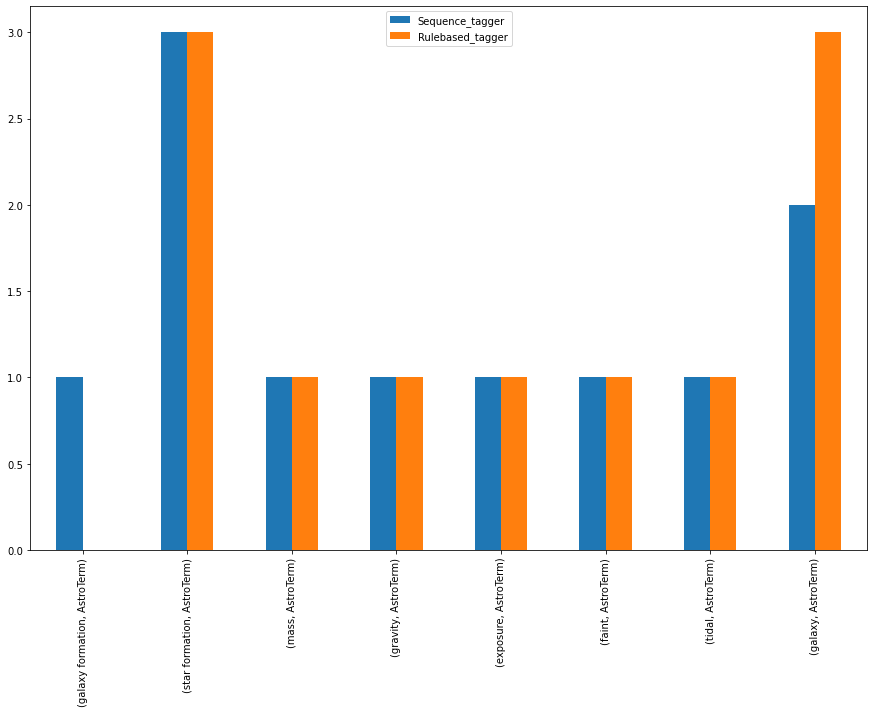

In [16]:
dfs = [pd.DataFrame(np.array(lst), 
                    columns=['idx', i]).set_index('idx')
          for i,lst in zip(['Sequence_tagger', 'Rulebased_tagger'],[terms_nn,terms_RB])]

df = pd.concat(dfs, axis=1)

ax = df.plot.bar()